C:\Users\fardo\AppData\Local\Temp\ipykernel_16660\819611254.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range("2023-01-01", periods=720, freq="H")  # 30 days of hourly data


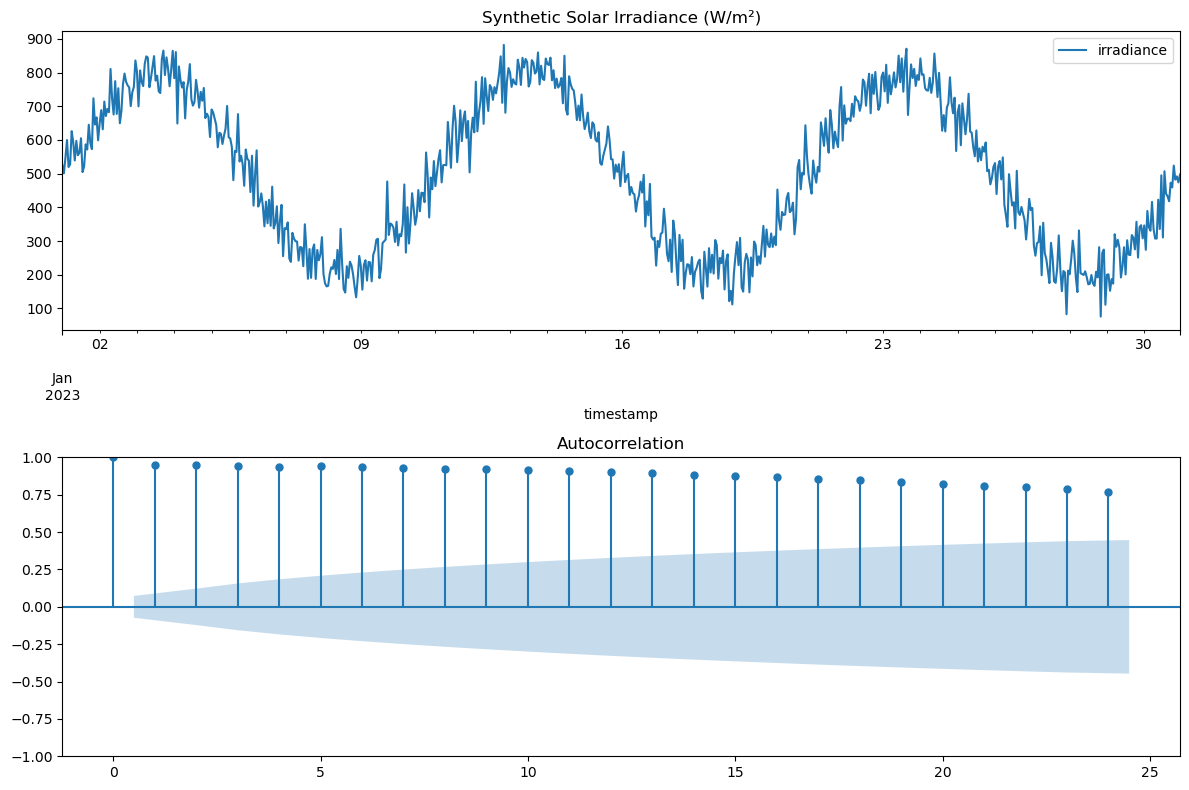

C:\Users\fardo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\fardo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\fardo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             irradiance   No. Observations:                  696
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3787.014
Date:                Sat, 07 Jun 2025   AIC                           7584.027
Time:                        00:59:49   BIC                           7606.747
Sample:                    01-01-2023   HQIC                          7592.813
                         - 01-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8913      0.167     -5.330      0.000      -1.219      -0.564
ar.L2         -0.1554      0.054     -2.873      0.004      -0.261      -0.049
ma.L1          0.1544      0.164      0.942      0.3

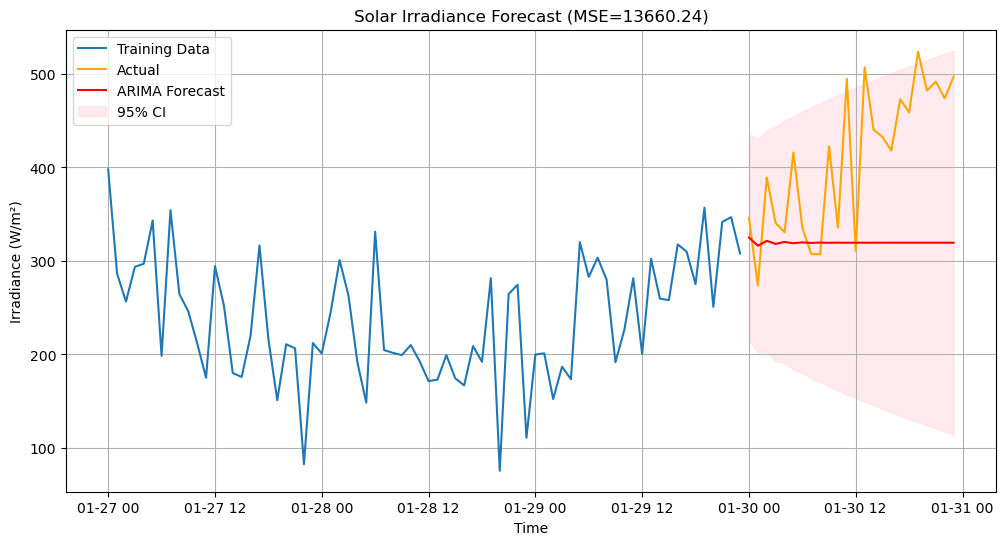

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

# --- Step 1: Generate Synthetic Solar Irradiance Data ---
np.random.seed(42)
time_index = pd.date_range("2023-01-01", periods=720, freq="H")  # 30 days of hourly data
base_irradiance = 500 + 300 * np.sin(np.linspace(0, 6*np.pi, 720))  # Diurnal cycle
noise = 50 * np.random.randn(720)  # Add noise
synthetic_irradiance = np.maximum(0, base_irradiance + noise)  # Ensure non-negative

# Create DataFrame
df = pd.DataFrame({
    "timestamp": time_index,
    "irradiance": synthetic_irradiance
}).set_index("timestamp")

# --- Step 2: Exploratory Analysis ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
df.plot(ax=ax1, title="Synthetic Solar Irradiance (W/m²)")
plot_acf(df["irradiance"], lags=24, ax=ax2)  # Check autocorrelation
plt.tight_layout()
plt.savefig("acf_plot.png")
plt.show()

# --- Step 3: Train-Test Split ---
train = df.iloc[:-24]  # Last 24 hours for testing
test = df.iloc[-24:]

# --- Step 4: Fit ARIMA Model ---
# Determine (p,d,q) using ACF/PACF (here: p=2, d=1, q=2)
model = ARIMA(train["irradiance"], order=(2,1,2))
fitted_model = model.fit()
print(fitted_model.summary())

# --- Step 5: Forecast ---
forecast = fitted_model.get_forecast(steps=24)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# --- Step 6: Evaluate & Plot ---
mse = mean_squared_error(test["irradiance"], forecast_mean)
print(f"\nMSE: {mse:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(train.index[-72:], train["irradiance"][-72:], label="Training Data")
plt.plot(test.index, test["irradiance"], label="Actual", color="orange")
plt.plot(test.index, forecast_mean, label="ARIMA Forecast", color="red")
plt.fill_between(
    test.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color="pink",
    alpha=0.3,
    label="95% CI"
)
plt.title(f"Solar Irradiance Forecast (MSE={mse:.2f})")
plt.xlabel("Time")
plt.ylabel("Irradiance (W/m²)")
plt.legend()
plt.grid()
plt.savefig("arima_forecast.png")
plt.show()

# --- Save Forecast Results ---
forecast_df = pd.DataFrame({
    "timestamp": test.index,
    "actual": test["irradiance"],
    "forecast": forecast_mean,
    "lower_ci": conf_int.iloc[:, 0],
    "upper_ci": conf_int.iloc[:, 1]
})

In [2]:
forecast_df

,timestamp,actual,forecast,lower_ci,upper_ci
2023-01-30 00:00:00,2023-01-30 00:00:00,346.177786,325.107124,214.805752,435.408497
2023-01-30 01:00:00,2023-01-30 01:00:00,273.851117,316.264624,202.209449,430.319798
2023-01-30 02:00:00,2023-01-30 02:00:00,389.256238,321.482974,203.139683,439.826265
2023-01-30 03:00:00,2023-01-30 03:00:00,340.565733,318.206315,192.653893,443.758736
2023-01-30 04:00:00,2023-01-30 04:00:00,330.533860,320.315675,190.675351,449.955998
2023-01-30 05:00:00,2023-01-30 05:00:00,416.078149,318.944917,183.486268,454.403565
2023-01-30 06:00:00,2023-01-30 06:00:00,335.461902,319.838801,180.042384,459.635217
2023-01-30 07:00:00,2023-01-30 07:00:00,307.396297,319.255149,174.470608,464.039690
2023-01-30 08:00:00,2023-01-30 08:00:00,307.212149,319.636415,170.532890,468.739939
2023-01-30 09:00:00,2023-01-30 09:00:00,422.647355,319.387314,165.769183,473.005444
